In [36]:
# Suggestion
# Make this grad engine for Tensors rather than scalars
# Use Numpy to implement your multi-dim primitive objects and its jacobian matrices
# Incorporate functions: add, sub, mul, div, relu, sigmoid, min, max, 
# Take care of cases where a node would split into 2 components when moving forward then during backprop 2 gradients would flow back to this node
# and in this case the gradients add up to be the total upstream gradient reaching this node


In [37]:
# Sanity Checks:

# # Gradient of a vector is the same shape as the vector
# Check gradients during 

In [48]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    # Improved styling
    dot.attr('node', shape='record', style='filled', fillcolor='lightblue', color='black', fontcolor='black', fontsize='12', fontname='Helvetica')
    dot.attr('edge', color='gray', arrowsize='0.8', fontsize='10')

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a rectangular node with improved styling
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad))
        if n._op:
            # Create a diamond-shaped node for operations with distinct styling
            dot.node(name=uid + n._op, label=n._op, shape='diamond', style='filled', fillcolor='orange')
            # Connect this operation node to its result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect input nodes to the operation node
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [82]:
from micrograd.engine import Value #This is Karpathy's Micrograd

In [40]:
a = Value(-4.0)
b = Value(2)
c = a+b
d = a*b + b**3
c += c + 1
c += c + 1 + (-a)
d += d*2 + (b+a).relu()
d += d*3 + (b-a).relu()
e =  c-d
f = e**2
g = f/2.0
g += 10.0/f
print(g.data)
g.backward()
print("dg/da = ",a.grad)
print(type(a))

24.70408163265306
dg/da =  138.83381924198252
<class 'micrograd.engine.Value'>


In [141]:

# Quant Class definition
import math
class Quant:
    def __init__(self, data,_children =(),_op = '',label = f'' ):
        self.data =  data
        self._backward = lambda : None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Quant(data = {self.data})"
    
    def __add__(self,other):
        out = Quant(data=self.data +other.data,_children = (self,other),_op = '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0* out.grad
            
        out._backward = _backward
        
        return out
    
    def __mul__(self,other):
        out = Quant(self.data*other.data,(self,other),_op='*')
        
        def _backward():
            self.grad = other.data*out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
        
    def sigmoid(self,):
        sigmoid = 1.0/(1.0+math.exp(self.data)+1.0)
        out = Quant(data=sigmoid,_children=(self,),_op='sigmoid')
        
        def _backward():
            self.grad = out.grad * sigmoid * (1-sigmoid)
        
        out._backward = _backward
        
        return out
            
    def tanh(self,):
        tanh = (math.exp(self.data) - math.exp(-self.data))/(math.exp(self.data)+math.exp(-self.data))
        out = Quant(data=tanh,_children =  (self,),_op = 'tanh')
        
        def _backward():
            self.grad = (1-tanh**2)*out.grad 
        
        out._backward = _backward
        return out
    
    
    def backward(self,):
        topo= []
        visited = set()
        def topo_sort(vertex):
            if vertex not in visited:
                visited.add(vertex)
                for child in vertex._prev:
                    topo_sort(child)
                topo.append(vertex)
        topo_sort(self)
        
        for node in reversed(topo):
            node._backward()
        print(topo)
        
            
                    
            

In [142]:
# Creating forward pass scenario
       
a =Quant(1.0,label=f'a')
b =Quant(-1.0,label = f'b')
c = Quant(-1.0,label = f'c')
d = a*b;d.label = f'd'
e1 = d+c; e1.label = f'e1'
e2 = e1.sigmoid(); e2.label = f'e2'
L = e2.tanh(); L.label = 'L'

quant_nodes = [a,b,c,d,e1,e2,L]

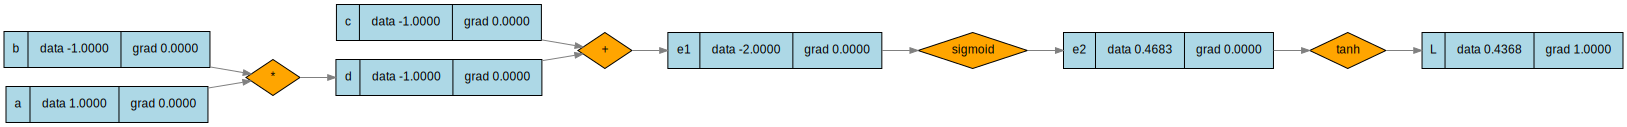

In [143]:
L.grad = 1.0    
draw_dot(L)

[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.43683324520239253)]
[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.43683324520239253)]
[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.43683324520239253)]
[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.43683324520239253)]
[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.43683324520239253)]
[Quant(data = -1.0), Quant(data = 1.0), Quant(data = -1.0), Quant(data = -1.0), Quant(data = -2.0), Quant(data = 0.4683105308334812), Quant(data = 0.436833

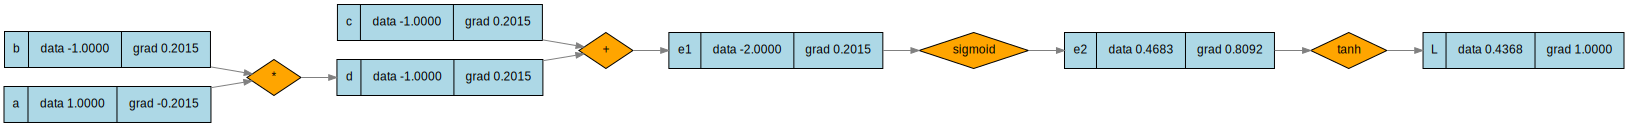

In [144]:

L.backward()
draw_dot(L)



[Quant(data = 3.0), Quant(data = -2.0), Quant(data = -6.0), Quant(data = 1.0), Quant(data = -6.0)]
[Quant(data = 3.0), Quant(data = -2.0), Quant(data = -6.0), Quant(data = 1.0), Quant(data = -6.0)]
[Quant(data = 3.0), Quant(data = -2.0), Quant(data = -6.0), Quant(data = 1.0), Quant(data = -6.0)]
[Quant(data = 3.0), Quant(data = -2.0), Quant(data = -6.0), Quant(data = 1.0), Quant(data = -6.0)]
[Quant(data = 3.0), Quant(data = -2.0), Quant(data = -6.0), Quant(data = 1.0), Quant(data = -6.0)]


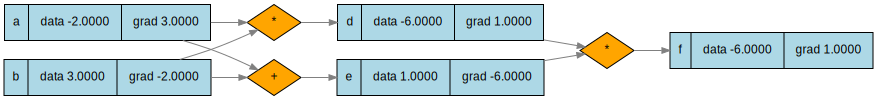

In [145]:
def lol():
    a = Quant(data = -2.0,label='a')
    b = Quant(data = 3.0,label = 'b')
    d = a*b; d.label = 'd'
    e = a+b; e.label = 'e'
    f = d*e; f.label = 'f'
    f.grad = 1.0
    f.backward()
    display(draw_dot(f))
lol()